<a href="https://colab.research.google.com/github/gavincapriola/Stock-Return-Predictions-using-LSTMs/blob/main/PyTorch_Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df.head() # show the first 5 rows

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [3]:
df.tail() # show the last 5 rows

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [4]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [5]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approximate
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [6]:
# bulid the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1239, 20, 1) Y.shape (1239, 1)


In [7]:
# try autoregressive RNN model
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        out, _ = self.rnn(X, (h0, c0)) 

        # we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

In [8]:
model = RNN(1, 5, 1, 1)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model.to(device)

Using device: cuda:0


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [11]:
# training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # backward and optimize
        loss.backward()
        optimizer.step()

        # save losses
        train_losses[it] = loss.item()

        # test losses
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 10 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

In [12]:
# make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [13]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [14]:
train_losses, test_losses = full_gd(model, 
                                    criterion, 
                                    optimizer, 
                                    X_train, 
                                    y_train, 
                                    X_test, 
                                    y_test)

Epoch 10/200, Train Loss: 0.0880, Test Loss: 1.1599
Epoch 20/200, Train Loss: 0.0156, Test Loss: 0.2420
Epoch 30/200, Train Loss: 0.0097, Test Loss: 0.0237
Epoch 40/200, Train Loss: 0.0063, Test Loss: 0.0436
Epoch 50/200, Train Loss: 0.0061, Test Loss: 0.0298
Epoch 60/200, Train Loss: 0.0056, Test Loss: 0.0279
Epoch 70/200, Train Loss: 0.0054, Test Loss: 0.0332
Epoch 80/200, Train Loss: 0.0054, Test Loss: 0.0240
Epoch 90/200, Train Loss: 0.0053, Test Loss: 0.0240
Epoch 100/200, Train Loss: 0.0053, Test Loss: 0.0192
Epoch 110/200, Train Loss: 0.0053, Test Loss: 0.0173
Epoch 120/200, Train Loss: 0.0052, Test Loss: 0.0158
Epoch 130/200, Train Loss: 0.0052, Test Loss: 0.0146
Epoch 140/200, Train Loss: 0.0052, Test Loss: 0.0137
Epoch 150/200, Train Loss: 0.0051, Test Loss: 0.0131
Epoch 160/200, Train Loss: 0.0051, Test Loss: 0.0127
Epoch 170/200, Train Loss: 0.0051, Test Loss: 0.0125
Epoch 180/200, Train Loss: 0.0051, Test Loss: 0.0124
Epoch 190/200, Train Loss: 0.0051, Test Loss: 0.0124
Ep

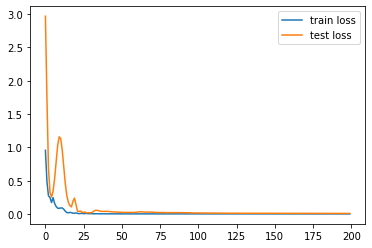

In [15]:
# plot the train and test losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [16]:
# one-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].reshape(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1
    
    # update the predictions list
    validation_predictions.append(p)

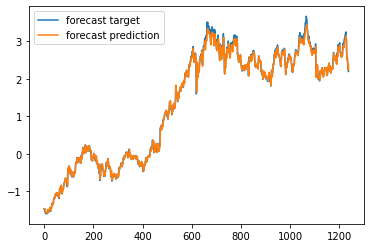

In [17]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [18]:
# multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar
    
    # update the predictions list
    validation_predictions.append(p[0,0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

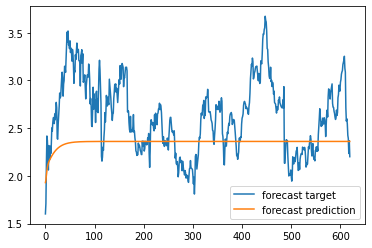

In [19]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()